# Defining the Environment

In [1]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple("Point", "x, y")

# we substitute pygame.init() for the explicit init of inititng the display and fonts
# this will prevent sound init, which may cause issues on notebooks
pygame.display.init()
pygame.font.init()

font = pygame.font.Font(pygame.font.get_default_font(), 25)

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 20
SPEED = 120

class SillySnakeGameAi:

    def __init__(self, width=640, height=480, playerName="Player"):
        self.w = width
        self.h = height
        self.playerName = playerName

        # init display

        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption("Silly Snake")
        self.clock = pygame.time.Clock()

        # init game
        self.reset()

    def reset(self):
        self.direction = Direction.RIGHT
        self.head = Point(self.w / 2, self.h / 2)
        self.snake = [self.head,
                      Point(self.head.x - BLOCK_SIZE, self.head.y),
                      Point(self.head.x - (2 * BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None

        self.placeFood()

        self.frameIteration = 0


    def placeFood(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self.placeFood()

    def playStep(self, action):
        # increment frame iteration

        self.frameIteration += 1

        for event in pygame.event.get():
            if event == pygame.QUIT:
                pygame.quit()
                quit()

        # 2. move the snake, asta creste si marimea sarpelui
        self.moveSnake(action)

        # reward stuff
        reward = 0

        # 3. check if game over

        if self.isCollision() or self.frameIteration > 100 * len(self.snake):
            gameOver = True

            reward -= 10

            return reward, gameOver, self.score

        # 4. move snake or place food

        if self.head == self.food:
            self.score += 1
            reward = 10
            self.placeFood()
        else:
            self.snake.pop()

        # 5. update ui and clock
        self.updateUi()
        self.clock.tick(SPEED)
        # 6. return game over and score
        gameOver = False

        return reward, gameOver, self.score

    def isCollision(self, p: Point = None):

        if p == None:
            p = self.head

        #check if it hits border
        if p.x > self.w - BLOCK_SIZE or p.x < 0:
            return True

        if p.y > self.h - BLOCK_SIZE or p.y < 0:
            return True

        # check if it hits itself

        if p in self.snake[1:]:
            return True

        return False

    def moveSnake(self, action):

        # action -> [straigth, right, left]
        clockWiseDirections = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        currentDirectionIndex = clockWiseDirections.index(self.direction)

        newDirection = self.direction

        if np.array_equal(action, [0, 1, 0]):
            newDirection = clockWiseDirections[(currentDirectionIndex + 1) % 4]
        elif np.array_equal(action, [0, 1, 0]):
            newDirection = clockWiseDirections[(currentDirectionIndex - 1) % 4]

        self.direction = newDirection

        x = self.head.x
        y = self.head.y

        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

        # this grows the size of our snake
        self.snake.insert(0, self.head)


    def updateUi(self):
        self.display.fill(BLACK)

        for p in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(p.x, p.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(p.x + 4, p.y + 4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        scoreText = font.render("Score: " + str(self.score) + " Speed: " + str(SPEED) + " Player: " + self.playerName, True, WHITE)

        self.display.blit(scoreText, [0, 0])

        pygame.display.flip()


    def setPlayerName(self, name):
        self.playerName = name

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Defining the Model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LinearQNet(nn.Module):

    def __init__(self, inputSize, hiddenSize, outputSize):
        super().__init__()

        self.linear1 = nn.Linear(inputSize, hiddenSize)
        self.linear2 = nn.Linear(hiddenSize, outputSize)

    def forward(self, X):
        out = self.linear1(X)
        out = F.relu(out)
        out = self.linear2(out)

        return out

# Training model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QTrainner:

    def __init__(self, model, lr, gamma):
        self.model = model
        self.lr = lr
        self.gamma = gamma

        self.optimizer = optim.Adam(model.parameters(), self.lr)
        self.lossFunction = nn.MSELoss()

    def trainStep(self, state, action, reward, newState, done):

        stateTensor = torch.tensor(state, dtype=torch.float)
        actionTensor = torch.tensor(action, dtype=torch.long)
        rewardTensor = torch.tensor(reward, dtype=torch.float)
        newStateTensor = torch.tensor(newState, dtype=torch.float)

        if len(stateTensor.shape) == 1:
            stateTensor = torch.unsqueeze(stateTensor, 0)
            newStateTensor = torch.unsqueeze(newStateTensor, 0)
            actionTensor = torch.unsqueeze(actionTensor, 0)
            rewardTensor = torch.unsqueeze(rewardTensor, 0)
            done = (done, )

        # 1. predicted q values with current state
        prediction = self.model(stateTensor)

        # Q_new = 2. reward + gamma * max(next predicted q value) -> only do this if not done
        target = prediction.clone()

        for i in range(len(done)):
            Qnew = rewardTensor[i]

            if not done[i]:
                Qnew = rewardTensor[i] + self.gamma * torch.max(self.model(newStateTensor[i]))

            target[i][torch.argmax(actionTensor).item()] = Qnew


        self.optimizer.zero_grad()
        loss = self.lossFunction(target, prediction)
        loss.backward()

        self.optimizer.step()

# Defining the agent

In [4]:
import torch
import random
import numpy as np
from collections import deque

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:
    def __init__(self):
        self.numberOfGames = 0
        # controls randomness
        self.epsilon = 0
        # discount rate
        self.gamma = 0
        # the last actions, if we reach the limit we will remove the oldest
        self.memory = deque(maxlen=MAX_MEMORY)

        # the modelneeds to have 11 inputs, as our world status grid has 11 elements and the output is 3, as we have 3 directions
        self.model = LinearQNet(11, 256, 3)
        self.trainner = QTrainner(self.model, lr=LR, gamma=self.gamma)

    # this gives us the state of the world
    def getState(self, game):
        head = game.head

        point_left = Point(head.x - BLOCK_SIZE, head.y)
        point_right = Point(head.x + BLOCK_SIZE, head.y)
        point_up = Point(head.x, head.y - BLOCK_SIZE)
        point_down = Point(head.x, head.y + BLOCK_SIZE)

        direction_left = game.direction == Direction.LEFT
        direction_right = game.direction == Direction.RIGHT
        direction_up = game.direction == Direction.UP
        direction_down = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (direction_right and game.isCollision(point_right)) or
            (direction_left and game.isCollision(point_left)) or
            (direction_up and game.isCollision(point_up)) or
            (direction_down and game.isCollision(point_down)),

            # Danger right
            (direction_up and game.isCollision(point_right)) or
            (direction_down and game.isCollision(point_left)) or
            (direction_left and game.isCollision(point_up)) or
            (direction_right and game.isCollision(point_down)),

            # Danger left
            (direction_down and game.isCollision(point_right)) or
            (direction_up and game.isCollision(point_left)) or
            (direction_right and game.isCollision(point_up)) or
            (direction_left and game.isCollision(point_down)),

            # Move direction
            direction_left,
            direction_right,
            direction_up,
            direction_down,

            # Food location
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
        ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, nextState, done):
        self.memory.append((state, action, reward, nextState, done))

    def trainLongMemory(self):
        if len(self.memory) < BATCH_SIZE:
            sample = self.memory
        else:
            sample = random.sample(self.memory, BATCH_SIZE)

        states, actions, rewards, nextStates, dones = zip(*sample)
        self.trainner.trainStep(states, actions, rewards, nextStates, dones)

    def trainShortMemory(self, state, action, reward, nextState, done):
        self.trainner.trainStep(state, action, reward, nextState, done)

    def getAction(self, state):
        # in the beginning will do some random moves, tradeoff between exploration and exploataition
        self.epsilon = 80 - self.numberOfGames
        finalMove = [0, 0, 0]

        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            finalMove[move] = 1
        else:
            stateTensor = torch.tensor(state, dtype=torch.float)
            prediction = self.model(stateTensor)
            move = torch.argmax(prediction).item()
            finalMove[move] = 1

        return finalMove

# Training and letting AI play the game

In [5]:
%%time

scoresHistory = []
meanScores = []

def train():
    
    totalScore = 0
    bestScore = 0

    agent = Agent()
    game = SillySnakeGameAi()

    # we train the model for 200 games
    while agent.numberOfGames < 200:

        game.setPlayerName("Machine epoch " + str(agent.numberOfGames))

        # get old state
        oldState = agent.getState(game)

        # move
        finalMove = agent.getAction(oldState)

        # perform move and get new state
        reward, done, score = game.playStep(finalMove)

        newState = agent.getState(game)

        # train short memory
        agent.trainShortMemory(oldState, finalMove, reward, newState, done)

        # remember
        agent.remember(oldState, finalMove, reward, newState, done)

        if done:
            # train long memory
            game.reset()
            agent.numberOfGames += 1
            agent.trainLongMemory()

            if score > bestScore:
                bestScore = score

            totalScore += score
            meanScore = (totalScore / agent.numberOfGames)

            scoresHistory.append(score)
            meanScores.append(meanScore)

            if score == bestScore or agent.numberOfGames % 10 == 0:
                print("Game number: ", agent.numberOfGames, "Score: ", score, "Best Score: ", bestScore, "Mean scores: ", meanScore)


# run the trainning method                
train()

C:\Users\aaish\AppData\Local\Temp\ipykernel_28452\2309456531.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  stateTensor = torch.tensor(state, dtype=torch.float)


Game number:  1 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  2 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  3 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  4 Score:  1 Best Score:  1 Mean scores:  0.25
Game number:  8 Score:  1 Best Score:  1 Mean scores:  0.25
Game number:  10 Score:  1 Best Score:  1 Mean scores:  0.3
Game number:  11 Score:  1 Best Score:  1 Mean scores:  0.36363636363636365
Game number:  13 Score:  1 Best Score:  1 Mean scores:  0.38461538461538464
Game number:  15 Score:  1 Best Score:  1 Mean scores:  0.4
Game number:  17 Score:  1 Best Score:  1 Mean scores:  0.4117647058823529
Game number:  19 Score:  3 Best Score:  3 Mean scores:  0.5263157894736842
Game number:  20 Score:  0 Best Score:  3 Mean scores:  0.5
Game number:  26 Score:  3 Best Score:  3 Mean scores:  0.5769230769230769
Game number:  30 Score:  1 Best Score:  3 Mean scores:  0.6
Game number:  32 Score:  3 Best Score:  3 Mean scores:  0.71875
Game number:  40 Score

# Plotting the trainning progress

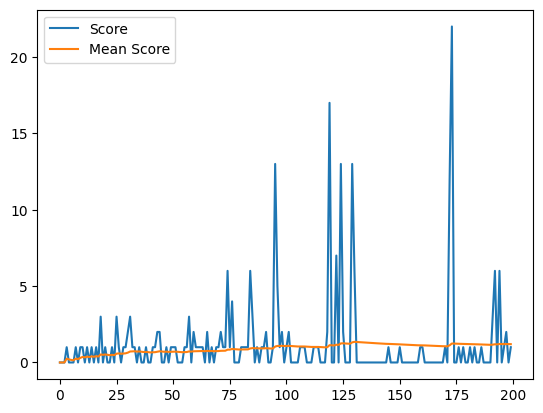

In [6]:
import matplotlib.pyplot as plt

plt.plot(scoresHistory)
plt.plot(meanScores)
plt.legend(["Score", "Mean Score"])